# Redes Neuronales Convolucionales (CNN)

Las redes neuronales convolucionales (CNN, por sus siglas en inglés) son una clase especial de redes neuronales diseñadas para procesar datos con una estructura de cuadrícula, como las imágenes. Las CNN son especialmente efectivas para tareas de visión por computadora, como la clasificación de imágenes, la detección de objetos y el reconocimiento facial.

## Utilidades

In [45]:
import torch
import torch.nn.functional as F

# (Ligera mejora) Hago que evaluate también devuelva el accuracy para poder usarlo en el bucle
def evaluate(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()  # Poner el modelo en modo evaluación
    correct = 0
    total = test_loader.dataset.__len__()  # Total de muestras en el conjunto de test
    with torch.no_grad():  # No calcular gradientes
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Mover datos al dispositivo
            outputs = model(inputs)  # Forward pass
            _, predicted = torch.max(outputs, 1)  # Obtener las predicciones
            correct += (predicted == labels).sum().item()  # Actualizar el contador de aciertos
    accuracy = 100 * correct / total if total > 0 else 0.0
    return accuracy


def train_with_validation(model, train_loader, dev_loader, criterion, optimizer, epochs=5):
    """
    Entrena 'model' durante 'epochs' usando train_loader y evalúa en dev_loader.
    Imprime acc y loss de train y dev por época.
    Devuelve (modelo_entrenado, history) donde history contiene listas por época.
    """

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)

    history = {
        'train_loss': [],
        'train_acc': [],
        'dev_loss': [],
        'dev_acc': [],
    }

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()  # Limpiar gradientes
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)  # Forward
            n_classes = outputs.shape[1]
            labels_one_hot = F.one_hot(labels, num_classes=n_classes).float()

            loss = criterion(outputs, labels_one_hot)  # Pérdida
            loss.backward()  # Backward
            optimizer.step()  # Update

            running_loss += loss.item()

            # Accuracy en train
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        avg_train_loss = running_loss / max(1, len(train_loader))
        train_acc = 100.0 * correct / max(1, total)

        # ---- Validación (loss) ----
        model.eval()
        dev_running_loss = 0.0
        with torch.no_grad():
            for inputs, labels in dev_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                n_classes = outputs.shape[1]
                labels_one_hot = F.one_hot(labels, num_classes=n_classes).float()
                dev_loss = criterion(outputs, labels_one_hot)
                dev_running_loss += dev_loss.item()
        avg_dev_loss = dev_running_loss / max(1, len(dev_loader))

        # ---- Validación (accuracy) usando tu función evaluate ----
        dev_acc = evaluate(model, dev_loader)  # imprime y devuelve accuracy

        # Guardar histórico
        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_acc)
        history['dev_loss'].append(avg_dev_loss)
        history['dev_acc'].append(dev_acc)

        # Log por época (conciso y claro)
        print(f'[Epoch {epoch + 1}] '
              f'train_loss: {avg_train_loss:.3f} | train_acc: {train_acc:.2f}% | '
              f'dev_loss: {avg_dev_loss:.3f} | dev_acc: {dev_acc:.2f}%')

    return model, history


In [46]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Dibuja las curvas de loss y accuracy (train y dev) guardadas en el diccionario 'history'.
    Espera claves: 'train_loss', 'train_acc', 'dev_loss', 'dev_acc'.
    """
    epochs = range(1, len(history['train_loss']) + 1)

    # --- Loss ---
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['dev_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)

    # --- Accuracy ---
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Accuracy')
    plt.plot(epochs, history['dev_acc'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


Clases del dataset CIFAR-10:
0: avión
1: automóvil
2: pájaro
3: gato
4: ciervo
5: perro
6: rana
7: caballo
8: barco
9: camión

--- Información del dataset ---
Número de imágenes de entrenamiento: 50000
Número de imágenes de prueba: 10000
Tamaño de una imagen: torch.Size([3, 32, 32])

--- Información del batch ---
Dimensión del batch de imágenes: torch.Size([32, 3, 32, 32])
Dimensión del batch de etiquetas: torch.Size([32])


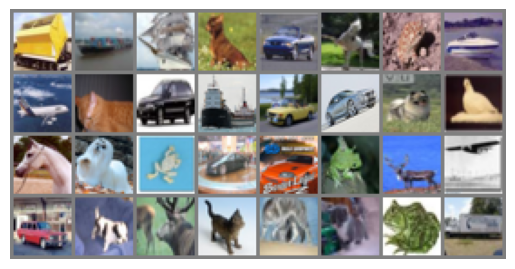

Etiquetas: camión | barco | barco | perro | automóvil | caballo | rana | barco | avión | gato | automóvil | barco | automóvil | automóvil | perro | pájaro | caballo | perro | rana | automóvil | automóvil | rana | ciervo | avión | automóvil | perro | ciervo | gato | gato | gato | rana | camión


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

BATCH_SIZE = 32

# --- Transformaciones básicas ---
transform = transforms.Compose([
    transforms.ToTensor(),  # Convertir a tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalización
])

# --- Descargar dataset CIFAR-10 ---
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# --- Crear dataloaders ---
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

# --- Nombres de las clases ---
classes = ('avión', 'automóvil', 'pájaro', 'gato', 'ciervo',
           'perro', 'rana', 'caballo', 'barco', 'camión')

print("Clases del dataset CIFAR-10:")
for i, c in enumerate(classes):
    print(f"{i}: {c}")

# --- Información sobre el dataset ---
print("\n--- Información del dataset ---")
print(f"Número de imágenes de entrenamiento: {len(train_set)}")
print(f"Número de imágenes de prueba: {len(test_set)}")
print(f"Tamaño de una imagen: {train_set[0][0].shape}")  # (3, 32, 32) -> RGB 32x32

# --- Obtener algunas imágenes del loader ---
dataiter = iter(train_loader)
images, labels = next(dataiter)

print("\n--- Información del batch ---")
print(f"Dimensión del batch de imágenes: {images.shape}")  # (batch_size, canales, alto, ancho)
print(f"Dimensión del batch de etiquetas: {labels.shape}")

# --- Función para mostrar imágenes ---
def imshow(img):
    img = img / 2 + 0.5     # Desnormalizar
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# --- Mostrar imágenes y etiquetas ---
imshow(torchvision.utils.make_grid(images))
print('Etiquetas:', ' | '.join(f'{classes[labels[j]]}' for j in range(len(labels))))

## Hiperparametros

In [48]:
# --- Configuración Hiperparámetros ---
EPOCHS = 5
LR = 1e-3

## Poner una semilla para los experimentos

Esto es importante para poder reproducir los resultados.

In [76]:
def seed_everything(seed):
    import random
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
    np.random.seed(seed)
    random.seed(seed)
        
seed_everything(42)

## Experimento 1 MLP

In [50]:
import torch
import torch.nn as nn
import torch.optim as optim

# Por si no está definido:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- MLP simple para CIFAR-10 sin Sequential ---
class SimpleMLP(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(3 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 3 * 32 * 32)  # Aplanar (batch, 3072)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)                # logits (sin softmax)
        return x

# --- Instanciar modelo ---
model = SimpleMLP().to(DEVICE)

# --- Criterio y optimizador ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

In [51]:
# --- Entrenamiento + validación ---
EPOCHS = 5
dev_loader = test_loader  # usar test como validación para el ejemplo

model, history = train_with_validation(
    model=model,
    train_loader=train_loader,
    dev_loader=dev_loader,
    criterion=criterion,
    optimizer=optimizer,
    epochs=EPOCHS
)

[Epoch 1] train_loss: 1.654 | train_acc: 41.10% | dev_loss: 1.543 | dev_acc: 45.58%
[Epoch 2] train_loss: 1.464 | train_acc: 48.12% | dev_loss: 1.454 | dev_acc: 48.48%
[Epoch 3] train_loss: 1.364 | train_acc: 51.52% | dev_loss: 1.425 | dev_acc: 49.79%
[Epoch 4] train_loss: 1.277 | train_acc: 54.71% | dev_loss: 1.412 | dev_acc: 50.45%
[Epoch 5] train_loss: 1.199 | train_acc: 57.26% | dev_loss: 1.423 | dev_acc: 51.30%


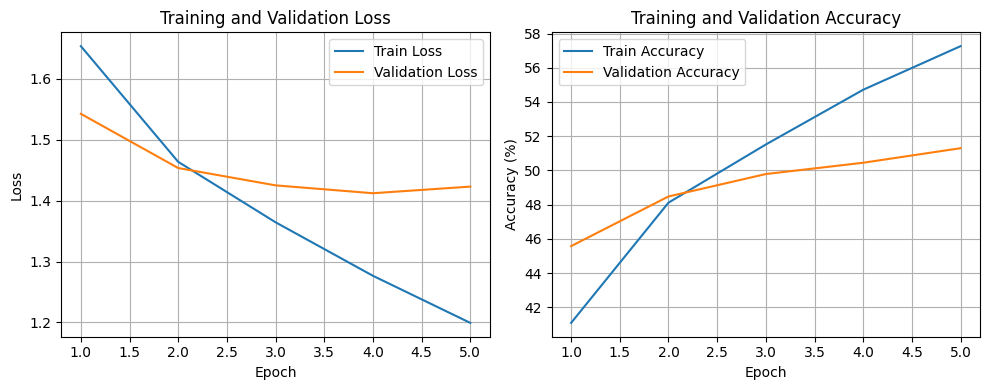

In [52]:
# --- Curvas de entrenamiento ---
plot_training_history(history)

In [53]:
# --- Evaluación final ---
print("\nEvaluación final en test:")
acc = evaluate(model, test_loader)
print(f'Accuracy final en test: {acc:.2f}%')


Evaluación final en test:
Accuracy final en test: 51.30%


## Experimento 2 CNN

In [54]:
# --- Definición de una CNN simple ---
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        # Capa 1: convolución + activación + pooling
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Capa 2: convolución + activación + pooling
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        # Capas totalmente conectadas
        self.fc1 = nn.Linear(32 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # dimension de la imagen de entrada: [B, 3, 32, 32]
        x = self.relu(self.conv1(x))
        # dimensión de la salida de la capa 1: [B, 16, 32, 32]
        x = self.pool(x)
        # dimensión de la salida del pooling: [B, 16, 16, 16]
        x = self.relu(self.conv2(x))
        # dimensión de la salida de la capa 2: [B, 32, 16, 16]
        x = self.pool(x)
        # dimensión de la salida del pooling: [B, 32, 8, 8]
        x = x.view(-1, 32 * 8 * 8)          # Aplanar
        x = self.relu(self.fc1(x))
        x = self.fc2(x)                      # logits
        return x

In [55]:
# --- Instanciar modelo ---
model_cnn = SimpleCNN().to(DEVICE)

# --- Criterio y optimizador ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cnn.parameters(), lr=LR)

In [56]:
# --- Entrenamiento + validación ---
EPOCHS = 5
dev_loader = test_loader  # usar test como validación para el ejemplo

model_cnn, history = train_with_validation(
    model=model_cnn,
    train_loader=train_loader,
    dev_loader=dev_loader,
    criterion=criterion,
    optimizer=optimizer,
    epochs=EPOCHS
)

[Epoch 1] train_loss: 1.413 | train_acc: 49.03% | dev_loss: 1.218 | dev_acc: 56.08%
[Epoch 2] train_loss: 1.058 | train_acc: 62.70% | dev_loss: 0.994 | dev_acc: 65.96%
[Epoch 3] train_loss: 0.894 | train_acc: 68.43% | dev_loss: 0.928 | dev_acc: 67.66%
[Epoch 4] train_loss: 0.788 | train_acc: 72.36% | dev_loss: 0.894 | dev_acc: 68.68%
[Epoch 5] train_loss: 0.702 | train_acc: 75.09% | dev_loss: 0.903 | dev_acc: 70.10%


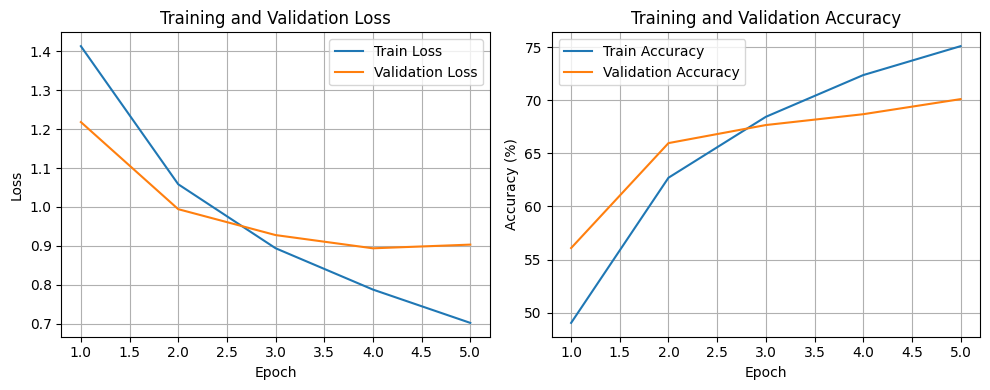

In [57]:
# --- Curvas de entrenamiento ---
plot_training_history(history)

In [58]:
# evaluación final ---
print("\nEvaluación final en test:")
acc = evaluate(model_cnn, test_loader)
print(f'Accuracy final en test: {acc:.2f}%')


Evaluación final en test:
Accuracy final en test: 70.10%


## Experimento 3 CNN + Data Augmentation + Dropout

In [70]:

# --- Transformaciones con data augmentation (solo para entrenamiento) ---
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),             # voltea horizontalmente algunas imágenes
    transforms.RandomRotation(10),                 # rotación aleatoria en ±10 grados
    transforms.ToTensor(),                         # convertir a tensor
    transforms.Normalize((0.5, 0.5, 0.5),          # normalización media y std por canal
                         (0.5, 0.5, 0.5))
])

# --- Transformaciones para test (sin augmentación) ---
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5))
])

# --- Descargar dataset CIFAR-10 ---
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

# --- Crear dataloaders ---
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

print("Data augmentation aplicado: HorizontalFlip, RandomCrop, RandomRotation")
print(f"Tamaño de dataset: {len(train_set)} imágenes de entrenamiento, {len(test_set)} de prueba")

Data augmentation aplicado: HorizontalFlip, RandomCrop, RandomRotation
Tamaño de dataset: 50000 imágenes de entrenamiento, 10000 de prueba


In [ ]:
class Cnn_dropout(nn.Module):
    def __init__(self, num_classes=10):
        super(Cnn_dropout, self).__init__()
        # Capa 1: convolución + activación + pooling
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Capa 2: convolución + activación + pooling
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        # Capas totalmente conectadas (Classifier)
        self.fc1 = nn.Linear(32 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        # dimension de la imagen de entrada: [B, 3, 32, 32]
        x = self.relu(self.conv1(x))
        # dimensión de la salida de la capa 1: [B, 16, 32, 32]
        x = self.pool(x)
        # dimensión de la salida del pooling: [B, 16, 16, 16]
        x = self.relu(self.conv2(x))
        # dimensión de la salida de la capa 2: [B, 32, 16, 16]
        x = self.pool(x)
        # dimensión de la salida del pooling: [B, 32, 8, 8]
        x = x.view(-1, 32 * 8 * 8)          # Aplanar
        x = self.relu(self.fc1(x))
        x = self.dropout(x)                  # Dropout en la capa totalmente conectada
        x = self.fc2(x)                      # logits
        return x

In [72]:
# --- Instanciar modelo ---
model_cnn_2 = Cnn_dropout().to(DEVICE)

# --- Criterio y optimizador ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cnn_2.parameters(), lr=LR)

In [73]:
# training + validación ---

dev_loader = test_loader  # usar test como validación para el ejemplo

model_cnn_2, history = train_with_validation(
    model=model_cnn_2,
    train_loader=train_loader,
    dev_loader=dev_loader,
    criterion=criterion,
    optimizer=optimizer,
    epochs=EPOCHS
)

[Epoch 1] train_loss: 1.448 | train_acc: 47.51% | dev_loss: 1.183 | dev_acc: 57.91%
[Epoch 2] train_loss: 1.159 | train_acc: 58.52% | dev_loss: 1.030 | dev_acc: 63.51%
[Epoch 3] train_loss: 1.041 | train_acc: 62.75% | dev_loss: 0.968 | dev_acc: 65.45%
[Epoch 4] train_loss: 0.971 | train_acc: 65.64% | dev_loss: 0.919 | dev_acc: 67.76%
[Epoch 5] train_loss: 0.918 | train_acc: 67.33% | dev_loss: 0.902 | dev_acc: 67.81%


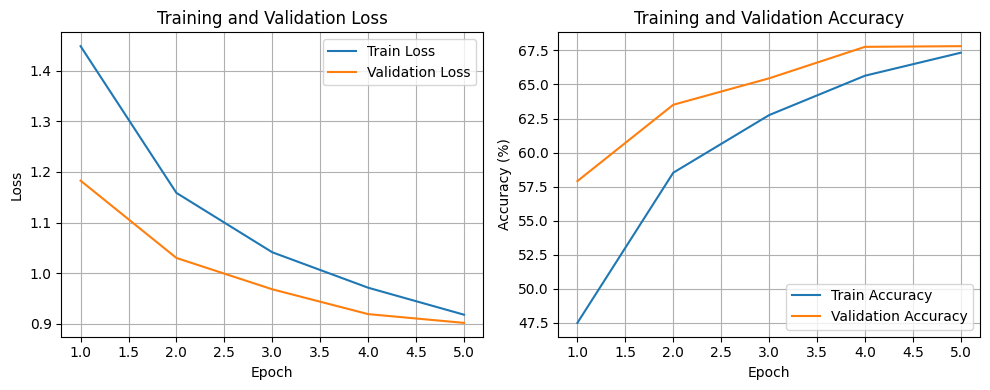

In [74]:
plot_training_history(history)

In [75]:
# evaluación final ---
print("\nEvaluación final en test:")
acc = evaluate(model_cnn_2, test_loader)
print(f'Accuracy final en test: {acc:.2f}%')


Evaluación final en test:
Accuracy final en test: 67.81%


## Ejercicios

1. Modificar la arquitectura de la CNN para mejorar su rendimiento.
2. Experimentar con diferentes técnicas de data augmentation.